In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from statsmodels.nonparametric.kernel_regression import KernelReg
import yfinance as yf
from datetime import datetime, timedelta
from backtester import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
def find_patterns(extrema, max_bars=35):
    """
    Input:
        extrema: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        patterns: patterns as a defaultdict list of tuples
        containing the start and end bar of the pattern
    """
    patterns = defaultdict(list)

    # Need to start at five extrema for pattern generation
    for i in range(5, len(extrema)+1):
        window = extrema.iloc[i-5:i]

        # A pattern must play out within max_bars (default 35)
        if (window.index[-1] - window.index[0]) > max_bars:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1, e3, e5])
        rtop_g2 = np.mean([e2, e4])
        
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['HS'].append((window.index[0], window.index[-1]))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):
            patterns['IHS'].append((window.index[0], window.index[-1]))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['BTOP'].append((window.index[0], window.index[-1]))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['BBOT'].append((window.index[0], window.index[-1]))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['TTOP'].append((window.index[0], window.index[-1]))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['TBOT'].append((window.index[0], window.index[-1]))

        # Rectangle Top
        elif (e1 > e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (min(e1, e3, e5) > max(e2, e4)):

            patterns['RTOP'].append((window.index[0], window.index[-1]))

        # Rectangle Bottom
        elif (e1 < e2) and \
                (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
                (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and \
                (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
                (max(e1, e3, e5) > min(e2, e4)):

            patterns['RBOT'].append((window.index[0], window.index[-1]))

    return patterns

## Designing a Head and Shoulders Short Trade Strategy

### Formatting the data to test the strategy

In [3]:
def format_data(data):
    """
    Strategy agnostic formatting of the data. Adds two columns: 
    - NDOpen: Next day open
    - NDDate: Next day date

    In daily strategies decisions are made on this price and this date. This is called inside the constructor of this
    class.
    """

    # STRATEGY AGNOSTIC COLUMNS
    nddate = data.index.values[1:] # tmp array for next day dates
    data["NDOpen"] = data.Open.shift(-1) # next day open: the price on which trade decisions made at the prev close are taken - with a laplacian perturbation added using modify_open()
    data = data.dropna() # dropping nan to make space for date[1:] values converted into datetime values 
    data["NDDate"] = pd.to_datetime(nddate) # next day date: the date on which trade decisions made at prev close are taken

    return data
    
def find_extrema(s, bw='cv_ls'):
    """
    Input:
        s: prices as pd.series
        bw: bandwith as str or array like
    Returns:
        prices: with 0-based index as pd.series
        extrema: extrema of prices as pd.series
        smoothed_prices: smoothed prices using kernel regression as pd.series
        smoothed_extrema: extrema of smoothed_prices as pd.series
    """
    # Copy series so we can replace index and perform non-parametric
    # kernel regression.
    prices = s.copy()
    prices = prices.reset_index()
    prices.columns = ['date', 'price']
    prices = prices['price']

    kr = KernelReg(
        [prices.values],
        [prices.index.to_numpy()],
        var_type='c', bw=bw
    )
    f = kr.fit([prices.index])

    # Use smoothed prices to determine local minima and maxima
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    smooth_local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    smooth_local_min = argrelextrema(smooth_prices.values, np.less)[0]
    local_max_min = np.sort(
        np.concatenate([smooth_local_max, smooth_local_min]))
    smooth_extrema = smooth_prices.loc[local_max_min]

    # Iterate over extrema arrays returning datetime of passed
    # prices array. Uses idxmax and idxmin to window for local extrema.
    price_local_max_dt = []
    for i in smooth_local_max:
        if (i > 1) and (i < len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].idxmax())

    price_local_min_dt = []
    for i in smooth_local_min:
        if (i > 1) and (i < len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].idxmin())

    maxima = pd.Series(prices.loc[price_local_max_dt])
    minima = pd.Series(prices.loc[price_local_min_dt])
    extrema = pd.concat([maxima, minima]).sort_index()

    # Return series for each with bar as index
    return extrema, prices, smooth_extrema, smooth_prices

def head_and_shoulders(extrema, index, max_bars=35, shoulder_sensitivity=0.03):
    """
    Input:
        extrema: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        dates: list of dates containing the start and end bar of the pattern
    """
    dates = []

    # Need to start at five extrema for pattern generation
    for i in range(5, len(extrema)+1):
        window = extrema.iloc[i-5:i]

        # A pattern must play out within max_bars (default 35)
        if (window.index[-1] - window.index[0]) > max_bars:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1, e3, e5])
        rtop_g2 = np.mean([e2, e4])

        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
                (abs(e1 - e5) <= shoulder_sensitivity*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= shoulder_sensitivity*np.mean([e1, e5])):

            #dates.append((index[window.index[0]], index[window.index[-1]]))
            dates.append([index[window.index[0]], index[window.index[-1]]])

    return dates


def obtain_pattern_data(data, max_bars, shoulder_sensitivity):

    pattern_data = [[0, 0]]

    dates = []

    for i in range(0, len(data)):

        # indexing the prices of interest
        prices = data["Close"][i:i+max_bars]

        # finding the extrema
        extrema, _, _, _ = find_extrema(prices, bw=[0.85])

        # only run head and shoulders when there are 5 extrema
        if len(extrema) >= 5:  

            # detecting the head and shoulders pattern
            dates = head_and_shoulders(extrema, prices.index, max_bars, shoulder_sensitivity)

        # checking if dates has any contents
        if len(dates) >= 1:

            # ensuring duplicate patterns are not saved
            if dates != pattern_data[-1][1]:

                # setting the pattern region as a variable
                pattern_region = data["Close"].loc[dates[0][0]:dates[0][1]]

                # the last two values are the target entry point and the stoploss - latter set to the pattern's head
                pattern_data.append([prices.index[-1], dates, pattern_region.min(), pattern_region.max()])

    return pattern_data[1:]


def obtain_entry_idx(df, detection_dates, pattern_data):

    idx_activate = []
    pattern_data_idx = []

    for i in range(len(pattern_data)):
        nxt_10_days = lite.loc[detection_dates[i]:detection_dates[i]+timedelta(days=10)].Close.le(pattern_data[i][2])

        try: 
            val = nxt_10_days[nxt_10_days == True].idxmin()
            idx_activate.append(val)
            pattern_data_idx.append(i)

        except:
            pass

    return idx_activate, pattern_data_idx


def format_strategy_data(data, max_bars, target_profit, shoulder_sensitivity):

    # obtaining pattern data
    pattern_data = obtain_pattern_data(data, max_bars, shoulder_sensitivity)

    # obtaining all potential patterns
    detection_dates = [pattern_data[i][0] for i in range(len(pattern_data))]

    # obtaining indices to initate positions, and idx of pattern_data list they correspond to
    idx_activate, sig_idx = obtain_entry_idx(data, detection_dates, pattern_data)

    # initialising unique strategy variables
    data["PatternDetected"] = 0
    data["GoShort"] = 0
    data["ShortStopLoss"] = 0
    data["PosTarget"] = 0 

    # storing indicator on dates when the pattern was detected
    data.loc[detection_dates, "PatternDetected"] = 1

    # storing indicator on dates to initate short position
    data.loc[idx_activate, "GoShort"] = 1

    # using sig_idx list to store stoploss variables stored in pattern_data 
    stoplosses = [pattern_data[sig_idx[i]][3] for i in range(len(sig_idx))]

    # storing stoploss and position targets for each short position
    for i in range(len(idx_activate)):
        data.loc[idx_activate[i], "ShortStopLoss"] = stoplosses[i] 
        data.loc[idx_activate[i], "PosTarget"] = data.loc[idx_activate[i]].NDOpen * (1 - target_profit)

    return data

In [4]:
lite = yf.Ticker("LITE").history(period="30y")
lite = format_data(lite)
max_bars = 35
target_profit = 0.05
shoulder_sensitivity = 0.03 # the lower this is, the closer the shoulder peaks and troughs need to be together
lite = format_strategy_data(lite, max_bars, target_profit, shoulder_sensitivity)

In [5]:
class Head_and_Shoulders(Backtest_Environment):
    
    # first line of arguments contains strategy specific parameters, second line contains backtest environment parameters
    def __init__(self, data, start_date, end_date,
                 start_cash, pos_size, tc, cooldown=1, 
                 max_executions=None, max_execution_period=None, cash_buffer=0, stoploss=None, trailing_stoploss=False):
        """
        Constructor method for the strategy child class. Extra arguments specific to the child can be added to this 
        constructor.
        
        The benefit of this is that, strategy specific parameters can be added to this class with the data preparation 
        methods occurring within the class prior to backtest(). 
        
        This structure allows for an easier defintion of new strategies for strategies with the similar rule structures
        but different parameters applied to those rules. 
        """
        
        # Calling the constructor of the parent class - stores input variables + adds strategy agnostic columns to the data
        super().__init__(data, start_cash, pos_size, tc, cooldown, max_executions, max_execution_period, cash_buffer, stoploss, trailing_stoploss)

        # Strategy specific parameters
        self.start_date = start_date
        self.end_date = end_date
    
    def process(self, data):
    
        if data.GoShort.values[0] == 1:
            num_units = int(np.floor((self.pos_size * self.cash_available) / data.Close.values[0]))

            if num_units == 0:
                        return 0

             # cash check - acts as a lid on opening new positions
            if (self.cash_available - num_units*data.Close.values[0]) > self.cash_buffer:

                return num_units, "Short"

            else:
                return 0

        return 0


    def monitorPosition(self, data, position):
    
        if data.Close.values[0] <= position.PosTarget.values[0]:

            return True

        elif data.Close.values[0] >= position.StopLoss.values[0] or data.High.values[0] >= position.StopLoss.values[0]:

            return True

        else:

            return False

In [6]:
strat = Head_and_Shoulders(lite, lite.index[0], lite.index[-1],
                         start_cash=1000, pos_size=1, tc=0.005, cooldown=0, 
                         max_executions=None, max_execution_period=None, cash_buffer=0)
strat.backtest()

True

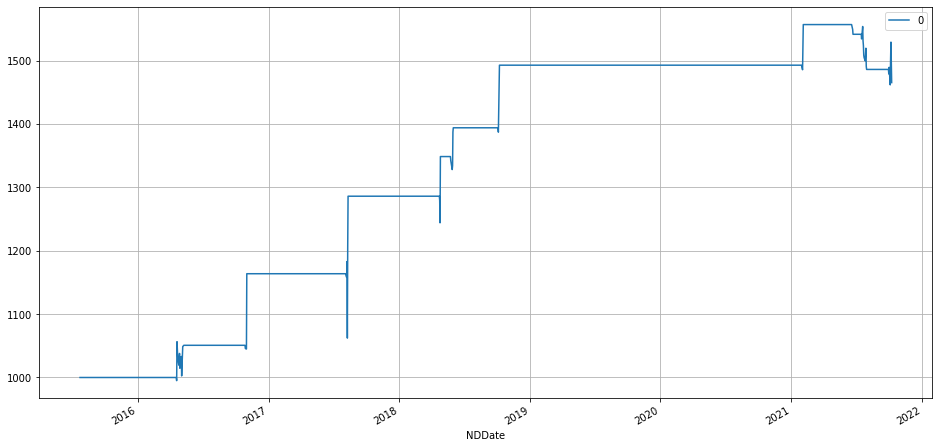

In [7]:
strat.portfolio_time_series.plot(figsize=(16,8))
plt.grid()
plt.show()

In [8]:
strat.stats.T

,0
Initial Capital,1000.000000
Ending Capital,1465.367091
Total Profit,465.367091
Total Profit Percentage,0.465367
Exposure,0.020000
Annual Return,0.063460
Annual Sharpe Ratio,0.619000
Annual Sortino Ratio,0.232000
Transaction Costs,119.635422
Portfolio Max DD Value,120.666000


In [9]:
strat.positions

,Status,PosType,PosID,Units,EntryPrice,EntryDate,PosTarget,StopLoss,PosVal,ExitPrice,ExitDate,CashGainLoss,PercGainPreTC,WinLoss,Max DD Value,Max DD Return,Holding Time
0,False,Short,185,38,26.223538,2016-04-19,24.576501,27.459999,996.494460,24.632354,2016-05-09,60.465002,0.060678,1.0,1.332,-0.050,20
0,False,Short,320,27,37.996321,2016-10-28,35.625000,44.500000,1025.900663,33.455550,2016-11-01,122.600823,0.119506,1.0,0.000,0.000,4
0,False,Short,513,19,60.020382,2017-08-07,57.000000,67.949997,1140.387252,53.016625,2017-08-11,133.071369,0.116690,1.0,5.673,-0.095,4
0,False,Short,692,23,54.928652,2018-04-24,52.059999,64.300003,1263.358989,51.675256,2018-04-26,74.828103,0.059229,1.0,0.000,0.000,2
0,False,Short,715,21,62.452122,2018-05-25,59.232499,64.500000,1311.494560,59.678941,2018-06-01,58.236795,0.044405,1.0,0.150,-0.002,7
0,False,Short,807,23,59.887291,2018-10-05,55.955001,63.150002,1377.407702,55.017367,2018-10-08,112.008267,0.081318,1.0,0.000,0.000,3
0,False,Short,1390,15,95.734667,2021-02-01,91.067001,108.930000,1436.020002,90.530961,2021-02-03,78.055586,0.054356,1.0,0.000,0.000,2
0,False,Short,1487,19,80.671041,2021-06-21,76.493997,81.940002,1532.749775,80.670810,2021-06-22,0.004390,0.000003,1.0,0.000,0.000,1
0,False,Short,1505,18,81.164065,2021-07-16,77.254000,83.980003,1460.953170,83.422363,2021-07-30,-40.649370,-0.027824,-1.0,4.094,-0.050,14


# Example of the code running retrospectively 
- This is useful for studying the behaviour of the asset and identifying common patterns

In [10]:
"""extrema, prices, smooth_extrema, smooth_prices = find_extrema(lite["Close"], bw=[0.85])
patterns = find_patterns(extrema, max_bars=35)
plt.plot(prices)
plt.scatter(extrema.index, extrema, color="red")
patterns"""

'extrema, prices, smooth_extrema, smooth_prices = find_extrema(lite["Close"], bw=[0.85])\npatterns = find_patterns(extrema, max_bars=35)\nplt.plot(prices)\nplt.scatter(extrema.index, extrema, color="red")\npatterns'